In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [2]:
# Creating a Ticker object for XMR-USD
xmr = yf.Ticker("XMR-USD")

# Downloading historical data for XMR-USD
# period="max" downloads data for the maximum available period
# interval="1d" downloads data at a daily interval
data = yf.download(tickers="XMR-USD", period="max", interval="1d")

data.head(10)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,112.531998,123.404999,112.219002,120.779999,120.779999,86864600
2017-11-10,121.344002,121.665001,101.757004,105.585999,105.585999,84614000
2017-11-11,105.750000,127.106003,103.877998,119.615997,119.615997,107708000
2017-11-12,119.597000,133.675003,110.617996,123.856003,123.856003,144948000
2017-11-13,128.960007,136.528000,120.921997,123.402000,123.402000,116200000
2017-11-14,123.615997,124.200996,118.625999,122.352997,122.352997,53544800
2017-11-15,122.240997,124.722000,119.192001,121.374001,121.374001,49976700
2017-11-16,121.242996,128.087997,118.504997,120.305000,120.305000,74944096
2017-11-17,120.014999,126.699997,119.250000,126.699997,126.699997,47127700


In [3]:
# Adding new features to the data
data["MA5"] = (
    data["Close"].rolling(window=5).mean()
)  # Moving Average for the last 5 days
data["MA10"] = (
    data["Close"].rolling(window=10).mean()
)  # Moving Average for the last 10 days
data["MA15"] = (
    data["Close"].rolling(window=15).mean()
)  # Moving Average for the last 15 days
data["STD5"] = (
    data["Close"].rolling(window=5).std()
)  # Standard Deviation of the price in the last 5 days
data["STD10"] = (
    data["Close"].rolling(window=10).std()
)  # Standard Deviation of the price in the last 10 days
data["Prev_Return"] = data["Close"].pct_change()  # Previous day returns
data = data.dropna()  # Dropping rows with missing values
# Displaying the new features
data.head()

,Open,High,Low,Close,Adj Close,Volume,MA5,MA10,MA15,STD5,STD10,Prev_Return
Date,,,,,,,,,,,,
2017-11-23,166.110001,172.919006,156.453995,158.606995,158.606995,109392000,146.307800,135.306999,129.753999,15.429907,15.772034,-0.044248
2017-11-24,158.619003,162.942001,156.761002,160.026993,160.026993,69178000,152.417398,139.074399,132.370466,12.948939,16.799975,0.008953
2017-11-25,159.994995,170.104004,159.994995,168.442001,168.442001,64076700,158.952798,143.781199,136.560866,10.447826,17.850505,0.052585
2017-11-26,168.572006,168.720001,159.763000,163.373993,163.373993,61100400,163.279996,148.088098,139.478065,4.068262,16.716647,-0.030088
2017-11-27,162.916000,173.391998,159.947998,173.391998,173.391998,81489696,164.768396,152.757298,142.780465,6.128826,16.599326,0.061319


In [4]:
# Converting the index to a datetime object and adding it as a new column
data["Date"] = pd.to_datetime(data.index)

# Adding a new column for the day of the week (Monday=0, Sunday=6)
data["DayOfWeek"] = data["Date"].dt.dayofweek

# Adding a new column for the month
data["Month"] = data["Date"].dt.month

# Adding a new column for the year
data["Year"] = data["Date"].dt.year

# Adding a new column for the day of the month
data["Day"] = data["Date"].dt.day

C:\Users\Sobhan\AppData\Local\Temp\ipykernel_20228\1649961229.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Date"] = pd.to_datetime(data.index)
C:\Users\Sobhan\AppData\Local\Temp\ipykernel_20228\1649961229.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["DayOfWeek"] = data["Date"].dt.dayofweek
C:\Users\Sobhan\AppData\Local\Temp\ipykernel_20228\1649961229.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [5]:
# Resetting the index of the DataFrame
data = data.reset_index(drop=True)

# Sorting the DataFrame by the "Date" column in ascending order
data = data.sort_values(by="Date", ascending=True)

# Displaying the first 10 rows of the DataFrame
data.head(10)

,Open,High,Low,Close,Adj Close,Volume,MA5,MA10,MA15,STD5,STD10,Prev_Return,Date,DayOfWeek,Month,Year,Day
0,166.110001,172.919006,156.453995,158.606995,158.606995,109392000,146.307800,135.306999,129.753999,15.429907,15.772034,-0.044248,2017-11-23,3,11,2017,23
1,158.619003,162.942001,156.761002,160.026993,160.026993,69178000,152.417398,139.074399,132.370466,12.948939,16.799975,0.008953,2017-11-24,4,11,2017,24
2,159.994995,170.104004,159.994995,168.442001,168.442001,64076700,158.952798,143.781199,136.560866,10.447826,17.850505,0.052585,2017-11-25,5,11,2017,25
3,168.572006,168.720001,159.763000,163.373993,163.373993,61100400,163.279996,148.088098,139.478065,4.068262,16.716647,-0.030088,2017-11-26,6,11,2017,26
4,162.916000,173.391998,159.947998,173.391998,173.391998,81489696,164.768396,152.757298,142.780465,6.128826,16.599326,0.061319,2017-11-27,0,11,2017,27
5,175.348007,203.210007,173.173004,203.210007,203.210007,179179008,173.688998,159.998399,148.100999,17.263827,21.131367,0.171969,2017-11-28,1,11,2017,28
6,203.912994,214.274994,165.330994,168.149994,168.149994,178828000,175.313599,163.865498,151.154132,15.992126,18.270445,-0.172531,2017-11-29,2,11,2017,29
7,170.485992,195.393997,156.531006,180.138000,180.138000,128112000,177.652798,168.302798,155.071732,15.585964,15.925320,0.071294,2017-11-30,3,11,2017,30
8,179.722000,191.848999,169.763000,190.938004,190.938004,70430496,183.165601,173.222798,159.780599,14.074326,14.326133,0.059954,2017-12-01,4,12,2017,1
9,190.834000,205.264008,186.684006,203.033997,203.033997,80791104,189.094000,176.931198,164.869532,15.131481,16.817433,0.063350,2017-12-02,5,12,2017,2


In [6]:
# Adding a new column "Target" to the DataFrame
# The value in the "Target" column is 1 if the price of the next day is higher than the current day, 0 otherwise
data["Target"] = (data["Close"].shift(-1) > data["Close"]).astype(int)

# Displaying the first 10 rows of the DataFrame
data.head(10)

,Open,High,Low,Close,Adj Close,Volume,MA5,MA10,MA15,STD5,STD10,Prev_Return,Date,DayOfWeek,Month,Year,Day,Target
0,166.110001,172.919006,156.453995,158.606995,158.606995,109392000,146.307800,135.306999,129.753999,15.429907,15.772034,-0.044248,2017-11-23,3,11,2017,23,1
1,158.619003,162.942001,156.761002,160.026993,160.026993,69178000,152.417398,139.074399,132.370466,12.948939,16.799975,0.008953,2017-11-24,4,11,2017,24,1
2,159.994995,170.104004,159.994995,168.442001,168.442001,64076700,158.952798,143.781199,136.560866,10.447826,17.850505,0.052585,2017-11-25,5,11,2017,25,0
3,168.572006,168.720001,159.763000,163.373993,163.373993,61100400,163.279996,148.088098,139.478065,4.068262,16.716647,-0.030088,2017-11-26,6,11,2017,26,1
4,162.916000,173.391998,159.947998,173.391998,173.391998,81489696,164.768396,152.757298,142.780465,6.128826,16.599326,0.061319,2017-11-27,0,11,2017,27,1
5,175.348007,203.210007,173.173004,203.210007,203.210007,179179008,173.688998,159.998399,148.100999,17.263827,21.131367,0.171969,2017-11-28,1,11,2017,28,0
6,203.912994,214.274994,165.330994,168.149994,168.149994,178828000,175.313599,163.865498,151.154132,15.992126,18.270445,-0.172531,2017-11-29,2,11,2017,29,1
7,170.485992,195.393997,156.531006,180.138000,180.138000,128112000,177.652798,168.302798,155.071732,15.585964,15.925320,0.071294,2017-11-30,3,11,2017,30,1
8,179.722000,191.848999,169.763000,190.938004,190.938004,70430496,183.165601,173.222798,159.780599,14.074326,14.326133,0.059954,2017-12-01,4,12,2017,1,1
9,190.834000,205.264008,186.684006,203.033997,203.033997,80791104,189.094000,176.931198,164.869532,15.131481,16.817433,0.063350,2017-12-02,5,12,2017,2,0


In [7]:
# Define the period for the test data
test_start_date = "2023-09-08"
test_end_date = "2023-10-07"

# Splitting the data into train, validation and test sets
test_data = data[(data["Date"] >= test_start_date) & (data["Date"] <= test_end_date)]
train_val_data = data[data["Date"] < test_start_date]

# Further splitting the train_val_data into training and validation sets
# Let's use approximately 80% of the data for training and 20% for validation
train_data = train_val_data[: int(1 * len(train_val_data))]
val_data = train_val_data[int(0.8 * len(train_val_data)) :]

# Separating X and y for each set
X_train = train_data.drop(columns=["Target", "Date"])
y_train = train_data["Target"]

X_val = val_data.drop(columns=["Target", "Date"])
y_val = val_data["Target"]

X_test = test_data.drop(columns=["Target", "Date"])
y_test = test_data["Target"]
scaler = StandardScaler()

# Fitting and transforming the training data
X_train_scaled = scaler.fit_transform(X_train)

# Only transforming the validation and test data
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
# Checking the shapes to ensure everything is in order
print(f"Training Data Shapes: {X_train.shape, y_train.shape}")
print(f"Validation Data Shapes: {X_val.shape, y_val.shape}")
print(f"Test Data Shapes: {X_test.shape, y_test.shape}")

Training Data Shapes: ((2115, 16), (2115,))
Validation Data Shapes: ((423, 16), (423,))
Test Data Shapes: ((30, 16), (30,))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found based on F1 score:  {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.6
Precision: 0.6
Recall: 1.0
F1 Score: 0.7499999999999999
ROC AUC Score: 0.5


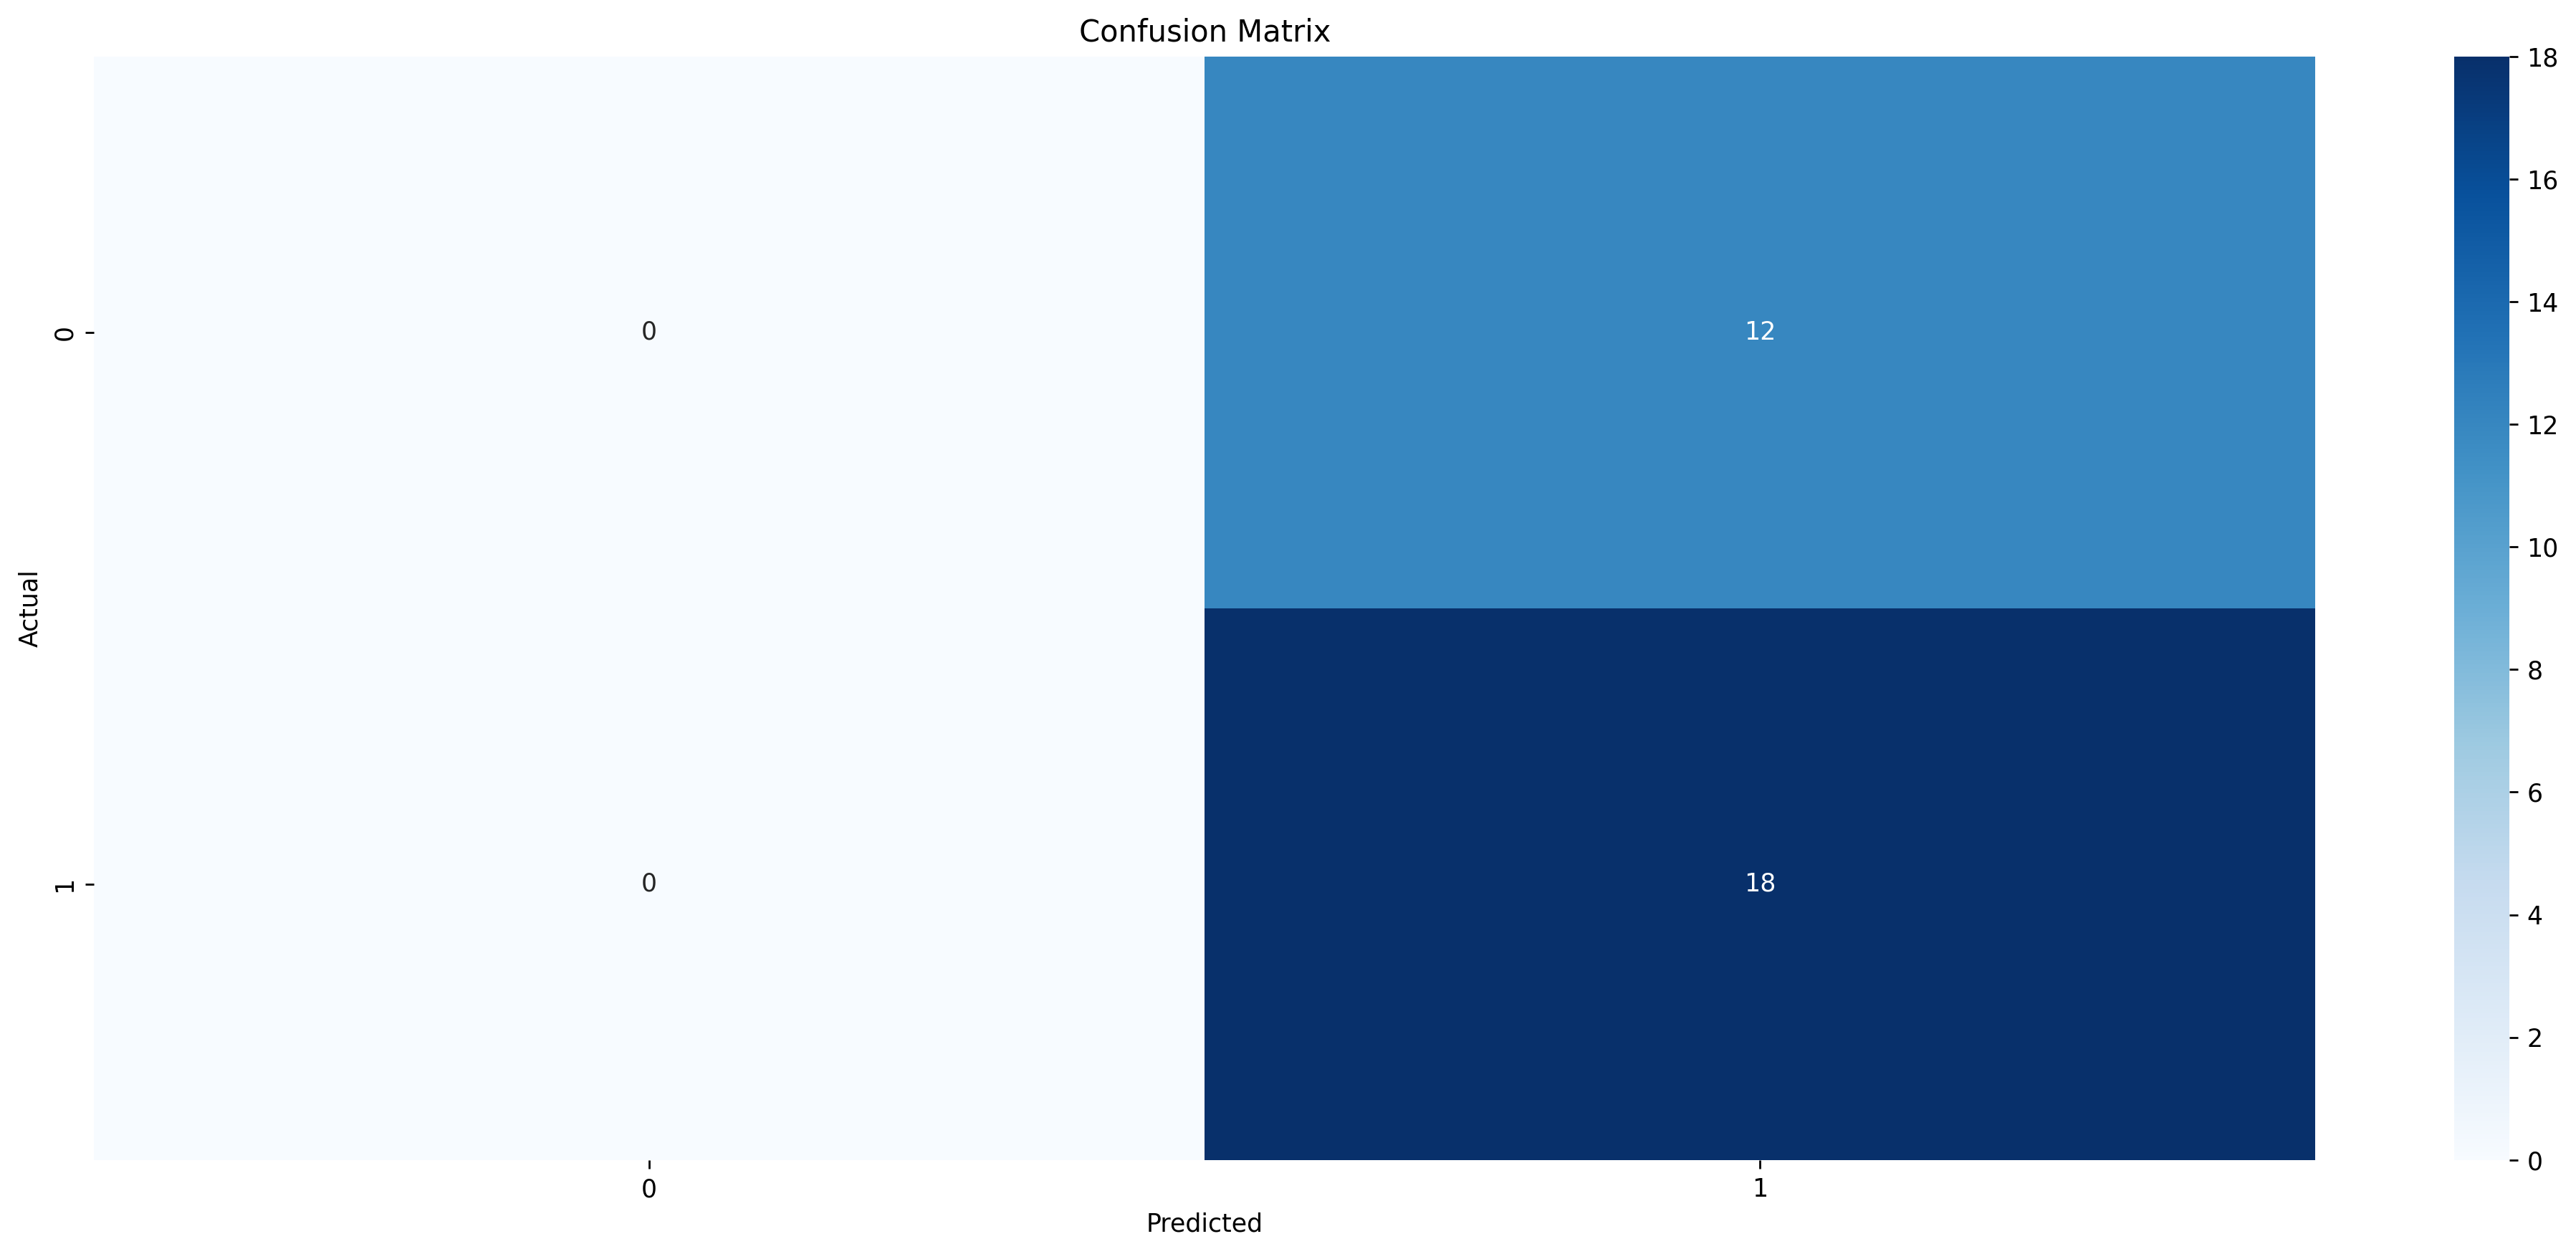

In [11]:
# Define the hyperparameters and their values to be tested
param_grid = {
    "C": [0.1, 1, 10, 100],  # Penalty parameter C of the error term
    "gamma": ["scale", "auto"],  # Kernel coefficient for 'rbf'
    "kernel": [
        "linear",
        "rbf",
    ],  # Kernel type to be used in the algorithm
}

# Initialize the GridSearchCV object with the hyperparameters, model, and scoring method
grid_search = GridSearchCV(SVC(), param_grid, refit=True, verbose=1, scoring="f1")

# Fit the model to the data
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found based on F1 score: ", best_params)

# Use the best model to predict the test data
best_svm_model = grid_search.best_estimator_
y_pred = best_svm_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)  # Accuracy of the model
precision = precision_score(y_test, y_pred)  # Precision of the model
recall = recall_score(y_test, y_pred)  # Recall of the model
f1 = f1_score(y_test, y_pred)  # F1 score of the model
roc_auc = roc_auc_score(y_test, y_pred)  # ROC AUC score of the model

# Display the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

# Confusion Matrix
# Set figure size and dpi
plt.figure(figsize=(20, 8), dpi=250)
conf_mat = confusion_matrix(y_test, y_pred)  # Confusion matrix of the model
sns.heatmap(conf_mat, annot=True, fmt="g", cmap="Blues")  # Plot the confusion matrix
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()